In [1]:
import cv2
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from keras.models import Sequential
from keras.optimizers import Adam
import glob
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

Using TensorFlow backend.


In [2]:
labels = sorted(os.listdir("trainer"))
global_labels = []
features = []
for i in labels:
    directory = os.path.join("trainer",i)
    for file in glob.iglob(directory+"/*"):
        image = cv2.imread(file,cv2.IMREAD_COLOR)
        image = cv2.resize(image,(150,150))
        features.append(np.array(image))
        global_labels.append(i)

In [3]:
X = np.array(features)

In [4]:
X.shape

(3000, 150, 150, 3)

In [5]:
len(global_labels)

3000

In [6]:
def define_model():
    model = Sequential([
        Conv2D(32,(5,5),activation="relu",padding="same",input_shape=(150,150,3)),
        MaxPooling2D((2,2)),
        Conv2D(64,(3,3),activation="relu",padding="same"),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3),activation="relu",padding="same"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128,activation="relu"),
        Dense(5,activation="softmax")
    ])
    model.compile(optimizer=Adam(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])
    return model

In [7]:
pp = LabelEncoder()
l = pp.fit_transform(global_labels)
y = to_categorical(l,num_classes=5)
X = X/255.0

In [8]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)
datagen.fit(x_train)

In [9]:
model = define_model()
history = model.fit_generator(datagen.flow(x_train,y_train,batch_size=32),epochs=50,
                              validation_data=(x_test,y_test),verbose=1,steps_per_epoch=x_train.shape[0]//32)

Epoch 1/50
70/70 [==============================] - 59s 849ms/step - loss: 1.5221 - accuracy: 0.3345 - val_loss: 1.1586 - val_accuracy: 0.5267
Epoch 2/50
70/70 [==============================] - 58s 824ms/step - loss: 1.1653 - accuracy: 0.5072 - val_loss: 1.0781 - val_accuracy: 0.5600
Epoch 3/50
70/70 [==============================] - 58s 826ms/step - loss: 1.0983 - accuracy: 0.5573 - val_loss: 0.9851 - val_accuracy: 0.6200
Epoch 4/50
70/70 [==============================] - 58s 832ms/step - loss: 1.0178 - accuracy: 0.5960 - val_loss: 0.9246 - val_accuracy: 0.6400
Epoch 5/50
70/70 [==============================] - 57s 819ms/step - loss: 0.9459 - accuracy: 0.6317 - val_loss: 0.8976 - val_accuracy: 0.6440
Epoch 6/50
70/70 [==============================] - 59s 842ms/step - loss: 0.9066 - accuracy: 0.6504 - val_loss: 0.8386 - val_accuracy: 0.6707
Epoch 7/50
70/70 [==============================] - 57s 810ms/step - loss: 0.8840 - accuracy: 0.6535 - val_loss: 0.7893 - val_accuracy: 0.7053

### Experimenting with various batch sizes, 32 worked pretty well

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

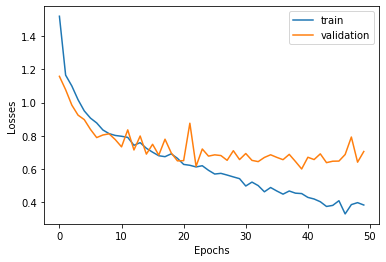

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend(['train','validation'])
plt.show()

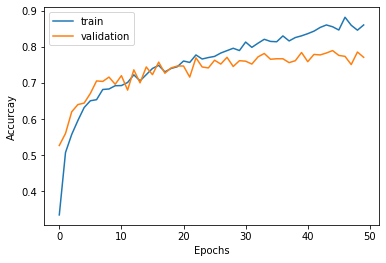

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accurcay')
plt.legend(['train','validation'])
plt.show()

In [47]:
item = ["daisy.jpeg","dandelion.jpeg","rose.jpeg","sunflower.jpeg","tulip.jpeg"]
test_labels = {0:"daisy",1:"dandelion",2:"rose",3:"sunflower",4:"tulip"}
for file in item:
        image = cv2.imread(file,cv2.IMREAD_COLOR)
        image = cv2.resize(image,(150,150))
        im = [np.array(image)]
        im = np.array(im)
        result = model.predict(im)
        result = np.argmax(result)
        for key in test_labels.keys():
            if result == key:
                print (result,test_labels.get(key,0))
        

0 daisy
1 dandelion
4 tulip
3 sunflower
4 tulip


### It gets everything right with the exception of the rose. It makes a wrong prediction by classifying a rose as a tulip